In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft 
from sklearn.decomposition import PCA


In [2]:
df=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df['time_s'] = np.arange(0,df.shape[0])/200 # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 200 Hz)
df=df.set_index('time_s')
df

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
time_s,,,,,,,,,,,,,,,,
0.000,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
0.005,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
0.010,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
0.015,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
0.020,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82.505,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
82.510,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
82.515,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502


In [3]:
#drop some columns 

new_df=df.drop(columns=['Log Mode','Log Freq','Timestamp','qw','qi','qj','qk'])

In [4]:
data=new_df.loc[6:71].copy()

In [5]:
#normalize dataset

data=(data-data.mean())
data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04,1.300100e+04
mean,2.880865e-14,-4.190240e-14,-2.513361e-12,2.436069e-15,3.848933e-15,-3.862485e-15,-3.794662e-14,2.702303e-13,2.593609e-13
std,7.105334e+00,5.720993e+00,1.463913e+01,1.461396e+00,7.408600e-01,3.951268e-01,1.328302e+00,1.973405e+00,3.039088e+00
min,-3.609259e+01,-3.304326e+01,-7.291116e+01,-8.800674e+00,-4.009284e+00,-4.080810e+00,-4.405046e+00,-6.625875e+00,-1.195770e+01
25%,-4.616589e+00,-3.519256e+00,-8.861159e+00,-6.174639e-01,-4.214974e-01,-2.487491e-01,-4.050458e-01,-1.625875e+00,-2.957696e+00
50%,8.041058e-02,2.627443e-01,-3.821591e-01,-6.784586e-02,-5.508543e-02,1.079311e-02,-4.050458e-01,3.741251e-01,4.230444e-02
75%,4.716411e+00,3.800744e+00,8.035841e+00,6.344441e-01,3.265936e-01,2.550679e-01,5.949542e-01,1.374125e+00,3.042304e+00
max,2.692041e+01,3.210474e+01,6.970684e+01,9.138261e+00,3.868579e+00,2.926824e+00,4.594954e+00,5.374125e+00,7.042304e+00


In [7]:
#performing PCA

acc_columns = ['AccX','AccY','AccZ']
gyro_columns= ['GyroX','GyroY','GyroZ']
magn_columns=['MagnX','MagnY','MagnZ']

In [40]:
def sensor_plot(data_frame, sensor, title, unit):
    
    #funzione che plotta gli assi dei sensori
    #title è una stringa
    #unit è una stringa (tipo '[mg]')
    #sensor vuole qualcosa del tipo "acc_columns = ['AccX','AccY','AccZ']"
    
    figure, axes = plt.subplots(1, 3, figsize=(22,3))
    figure.suptitle(title)    

    for i in range(3):
        data_frame.plot(ax=axes[i],y=sensor[i], ylabel= unit, xlabel='time [s]')
    


In [8]:
def clean_up(data_frame, sensor):
    
    #funzione che seleziona le componenti della PCA e toglie il drift
    #sensor vuole qualcosa del tipo "acc_columns = ['AccX','AccY','AccZ']"
        
    pca=PCA(n_components=2) 
    
    pca.fit(data_frame[sensor])
    sensorT=pca.transform(data_frame[sensor])  
    
    sensor_clean=np.zeros_like(sensorT)
    drift_sensor=np.zeros_like(sensorT)
    
    for i in range(2):
        drift_sensor[i]=np.polyfit(data_frame.index,sensorT[:,i],1)
        sensor_clean[:,i]=sensorT[:,i]-(drift_sensor[i,0]*data_frame.index + drift_sensor[i,1])
        
    return sensor_clean
        

In [33]:
def PCA_plot (data_frame, sensor, title, unit):
    
    #funzione che plotta le componenti della PCA e la sua FT
    #title è una stringa
    #unit è una stringa (tipo '[mg]')
    #sensor vuole qualcosa del tipo "acc_columns = ['AccX','AccY','AccZ']"
    
    sampling_rate = 200 
    sample_spacing = 1/sampling_rate
    
    pca=PCA(n_components=2) 
    pca.fit(data_frame[sensor])
    
    sensorT=pca.transform(data_frame[sensor]) 
    
    sensorT_FT1=fft.fft(sensorT[:,0])
    sensorT_FT2=fft.fft(sensorT[:,1])
    sensorT_FT_freq=fft.fftfreq(sensorT[:,0].size,sample_spacing)
    N = int(sensorT_FT_freq.size/2) 
    
    with plt.rc_context({"figure.figsize" : (20,6)}):
        fig,axs = plt.subplots(2,2)
        fig.suptitle(title)
        axs[0,0].plot(data_frame.index,sensorT[:,0],label='First component')
        axs[0,0].legend(loc='upper right')
        axs[0,0].set_title("Transformed vector's components projection")
        axs[0,0].set_ylabel(unit)
        axs[0,1].plot(sensorT_FT_freq[:N],np.abs(sensorT_FT1[:N]))
        axs[0,1].set_title("FT")
        axs[0,1].set_ylabel('power')
        axs[1,0].plot(data_frame.index,sensorT[:,1],label='Second component')
        axs[1,0].legend(loc='upper right')
        axs[1,0].set_xlabel('time [s]')
        axs[1,0].set_ylabel(unit)
        axs[1,1].plot(sensorT_FT_freq[:N],np.abs(sensorT_FT2[:N]))
        axs[1,1].set_xlabel('frequency [Hz]')
        axs[1,1].set_ylabel('power');

    print('*',title,'\n')
    print("Percentage of variance due to the first component: {:.2%}".format(pca.explained_variance_ratio_[0]))
    print("Percentage of variance due to the second component: {:.2%}".format(pca.explained_variance_ratio_[1]),'\n')


* Accelerometer PCA 

Percentage of variance due to the first component: 75.92%
Percentage of variance due to the second component: 13.91% 

* Gyroscope PCA 

Percentage of variance due to the first component: 79.96%
Percentage of variance due to the second component: 15.95% 

* Magnetoscope PCA 

Percentage of variance due to the first component: 81.08%
Percentage of variance due to the second component: 10.23% 



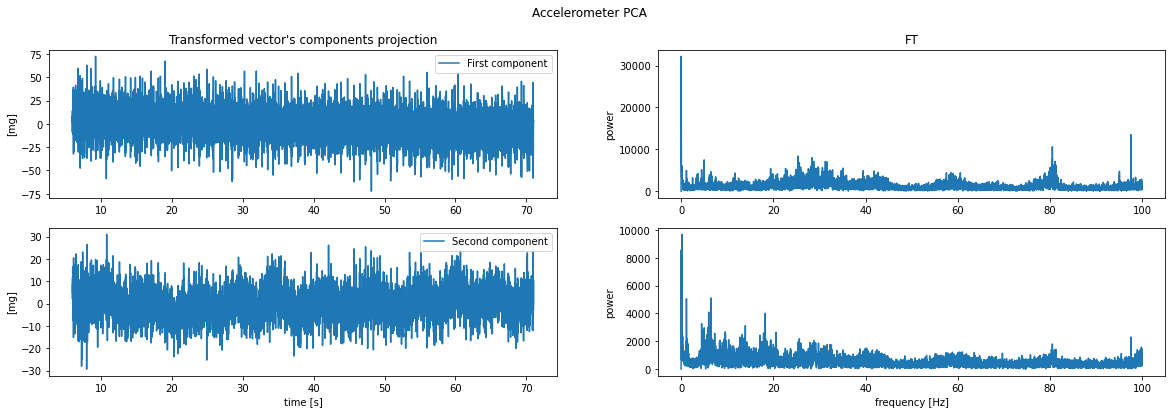

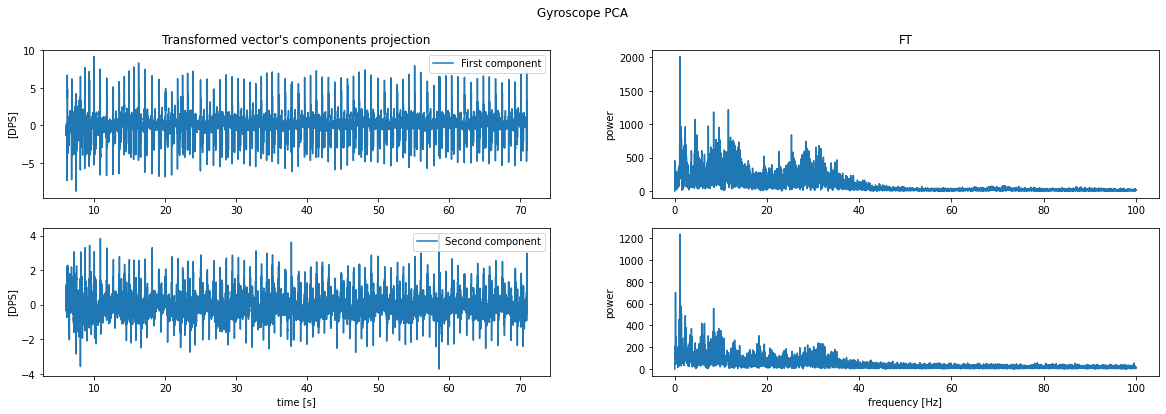

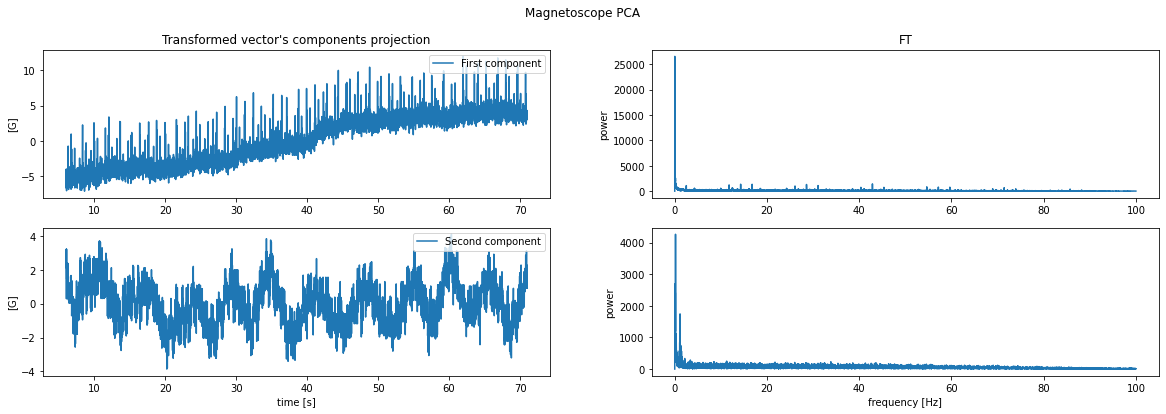

In [34]:
PCA_plot(data,acc_columns,'Accelerometer PCA','[mg]')
PCA_plot(data,gyro_columns,'Gyroscope PCA','[DPS]')
PCA_plot(data,magn_columns,'Magnetoscope PCA','[G]')

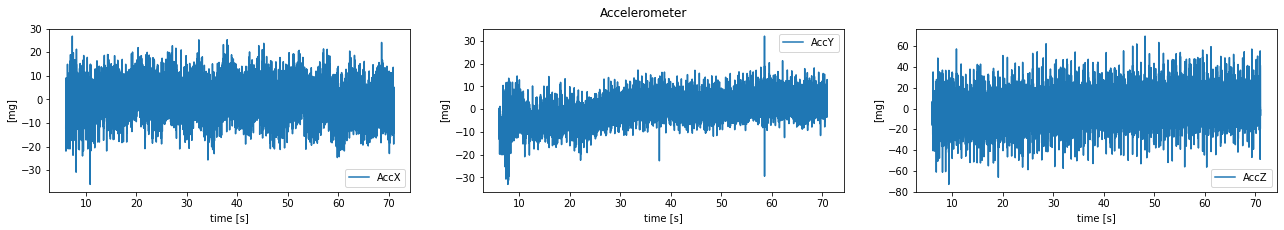

In [41]:
sensor_plot(data,acc_columns,'Accelerometer','[mg]')